# Zillow Rental Index models

## Sections

- <a href="#Importing-previously-imputed-data">Importing previously imputed data</a><br>
- <a href="#Random-Forest-regressor">Random Forest regressor</a><br>
- <a href="#Writing-CV-to-preserve-time-series-structure">Writing-CV-to-preserve-time-series-structure</a><br>
- <a href="#Random-Forest-on-metro-clusters">Random-Forest-on-metro-clusters</a><br>
- <a href="#Trying-forest-clusters-on-whole-data-set">Trying-forest-clusters-on-whole-data-set</a><br>
- <a href="#Comparing-model-predictions-for-NY-zip-code">Comparing-model-predictions-for-NY-zip-code</a><br>
- <a href="#Get-randomforest-predictions-using-principal-components">Get-randomforest-predictions-using-principal-components</a><br>
- <a href="#Arima-model-for-NY-zipcode">Arima-model-for-NY-zipcode</a><br>
- <a href="#Model-prediction-comparisons">Model-prediction-comparisons</a><br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import model_functions
%matplotlib inline

## Importing previously imputed data

In [2]:
zillow_data = pd.read_csv('../../data/ZillowMarch26.csv',dtype={'Zipcode':str})
zillow_data['Date'] = pd.to_datetime(zillow_data['Date'])

In [3]:
zillow_data.set_index('Date',inplace = True)

In [4]:
zillow_data.shape

(17751, 25)

In [5]:
zillow_data.dtypes

Zipcode                  object
City                     object
State                    object
Metro                    object
County                   object
SizeRank                  int64
Rent                    float64
Year                      int64
State-County             object
total_pop               float64
households              float64
median_age              float64
median_income           float64
income_per_capita       float64
gini_index              float64
pct_poverty             float64
housing_availability    float64
home_density            float64
pct_employed            float64
pct_jobs_nightlife      float64
pct_unemployed          float64
move_within_city        float64
move_new_city           float64
avg_commute_time        float64
pct_college             float64
dtype: object

In [6]:
zillow_data.isnull().sum().sort_values(ascending = False).head()
features = zillow_data.drop(['Rent','State-County','State','Year',
                             'City','Metro','County','Zipcode','SizeRank','pct_unemployed'],
                           axis = 1)
feature_cols = features.columns
X = features.copy()
y = np.log(zillow_data['Rent'])

In [7]:
#Get the range of dates in the dataset
print(X.index[0])
print(X.index[-1])

2015-01-01 00:00:00
2020-01-01 00:00:00


## Random Forest regressor

In [8]:
model, Xtest, ytest = model_functions.forest_regressor(zillow_data,'2018-08-01')

In [9]:
model.score(Xtest,ytest)

0.9467484220149174

In [10]:
rfc_imp = pd.DataFrame({'Columns':Xtest.columns,'Feature_importances':model.feature_importances_})

In [11]:
rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

,Columns,Feature_importances
3,median_income,0.280730
4,income_per_capita,0.174361
13,avg_commute_time,0.137493
14,pct_college,0.079121
7,housing_availability,0.061014
12,move_new_city,0.051264
5,gini_index,0.050830
9,pct_employed,0.035386
2,median_age,0.034299
11,move_within_city,0.026952


In [12]:
ypred = model.predict(Xtest)

In [13]:
RMSE = mean_squared_error(np.exp(ytest),np.exp(ypred), squared = False)
print(f'RMSE: ${round(RMSE,2)}')

RMSE: $136.36


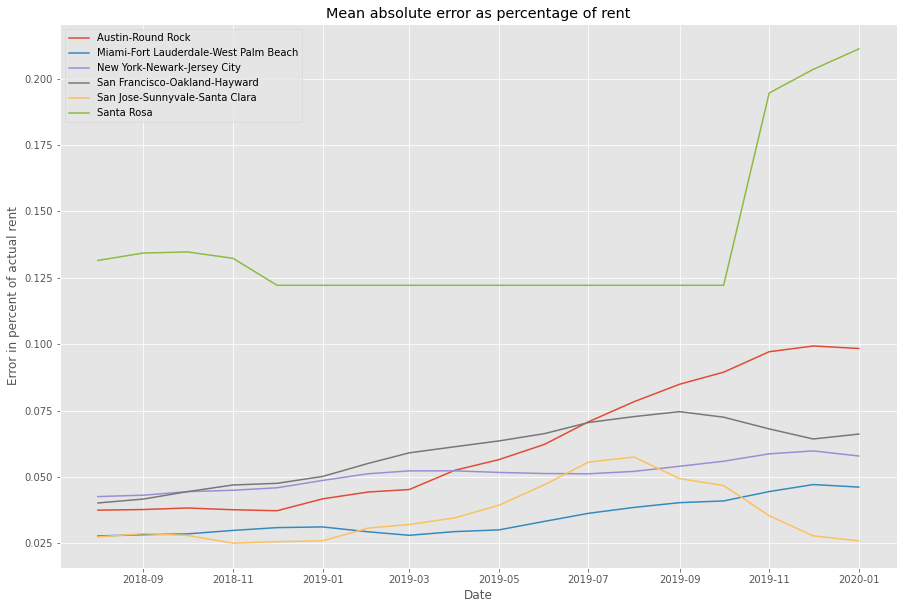

In [14]:
model_functions.abs_relative_error(ytest,ypred,zillow_data)

In [15]:
from sklearn.model_selection import GridSearchCV
estimators= list(map(int,np.linspace(400,700,4)))
param_grid = {'n_estimators':estimators}

In [16]:
grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid)

In [17]:
#GridSearch revealed best number of trees was 600


# grid.fit(Xtrain,ytrain)

In [18]:
# grid.best_params_

In [19]:
# grid.score(Xtest,ytest)

In [20]:
# grid.best_score_

In [21]:
# y_pred = grid.predict(Xtest)
# print(mean_squared_error(np.exp(ytest),np.exp(ypred),squared = False))

In [22]:
# rfc = RandomForestRegressor(n_estimators = 600)
# rfc.set_params(**grid.best_params_)

In [23]:
# rfc.fit(Xtrain,ytrain)

In [24]:
# rfc.score(Xtest,ytest)

In [25]:
# rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

# rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

## Writing CV to preserve time-series structure

In [26]:
rent_dates = zillow_data.index.unique()

train_end = 9
test_start = train_end
test_end = test_start +3

cv_dict = {'train_score':[],
              'test_score':[],
              'RMSE':[]}

predictions = []
rfc_cv = RandomForestRegressor()
rfc_cv.set_params(n_estimators = 600)

while test_end <=len(rent_dates):


    Xtrain = X[X.index.isin(rent_dates[:train_end])]
    ytrain = y[y.index.isin(rent_dates[:train_end])]
    Xtest = X[X.index.isin(rent_dates[test_start:test_end])]
    ytest = y[y.index.isin(rent_dates[test_start:test_end])]
    rfc_cv.fit(Xtrain,ytrain)
    cv_dict['train_score'].append(rfc_cv.score(Xtrain,ytrain))
    cv_dict['test_score'].append(rfc_cv.score(Xtest,ytest))
    cv_pred = rfc_cv.predict(Xtest)
    predictions.extend(cv_pred)
    cv_dict['RMSE'].append(mean_squared_error(np.exp(ytest),np.exp(cv_pred),squared = False))
    
    print(f'Training date range: {Xtrain.index.unique().tolist()[0]} : {Xtrain.index.unique().tolist()[-1]}')
    print(f'Testing date range: {Xtest.index.unique().tolist()[0]} : {Xtest.index.unique().tolist()[-1]}')
    print(f'Random forest test score: {rfc_cv.score(Xtest,ytest)}\n')
    train_end +=3
    test_start +=3
    test_end +=3

Training date range: 2015-01-01 00:00:00 : 2015-09-01 00:00:00
Testing date range: 2015-10-01 00:00:00 : 2015-12-01 00:00:00
Random forest test score: 0.9673599441113659

Training date range: 2015-01-01 00:00:00 : 2015-12-01 00:00:00
Testing date range: 2016-01-01 00:00:00 : 2016-03-01 00:00:00
Random forest test score: 0.9673238728599567

Training date range: 2015-01-01 00:00:00 : 2016-03-01 00:00:00
Testing date range: 2016-04-01 00:00:00 : 2016-06-01 00:00:00
Random forest test score: 0.9638200871663546

Training date range: 2015-01-01 00:00:00 : 2016-06-01 00:00:00
Testing date range: 2016-07-01 00:00:00 : 2016-09-01 00:00:00
Random forest test score: 0.9576580631946807

Training date range: 2015-01-01 00:00:00 : 2016-09-01 00:00:00
Testing date range: 2016-10-01 00:00:00 : 2016-12-01 00:00:00
Random forest test score: 0.9544188689155372

Training date range: 2015-01-01 00:00:00 : 2016-12-01 00:00:00
Testing date range: 2017-01-01 00:00:00 : 2017-03-01 00:00:00
Random forest test s

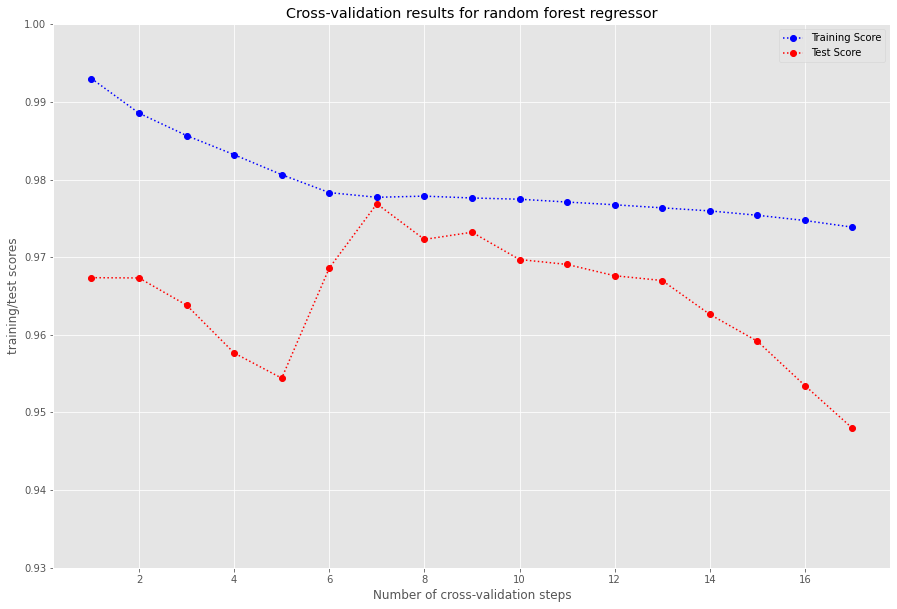

In [27]:
cv_results = pd.DataFrame(cv_dict)
cv_results.index = cv_results.index +1
plt.figure(figsize = (15,10))
plt.plot(cv_results['train_score'],'bo:')
plt.plot(cv_results['test_score'],'ro:')
plt.legend(['Training Score','Test Score'])
plt.xlabel('Number of cross-validation steps')
plt.ylabel('training/test scores')
plt.title('Cross-validation results for random forest regressor')
plt.ylim([.93,1])
plt.show()


In [28]:
print(cv_results['test_score'].mean())
print(cv_results.shape[0])

0.9645990121988044
17


Text(0.5, 1.0, 'Cross-validation results for random forest regressor')

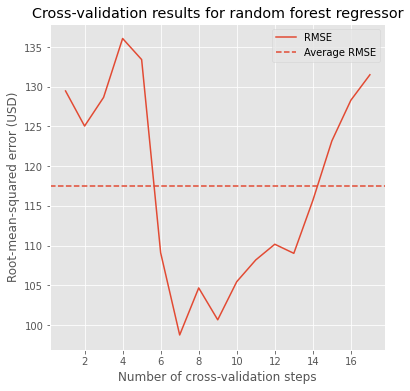

In [29]:
plt.figure(figsize = (6,6))
plt.plot(cv_results['RMSE'])
plt.xlabel('Number of cross-validation steps')
plt.ylabel('Root-mean-squared error (USD)')
plt.axhline(np.mean(cv_results['RMSE']),ls = '--')
plt.legend(['RMSE','Average RMSE'])
plt.title('Cross-validation results for random forest regressor')

## Random Forest on metro clusters

In [30]:
atx = pd.read_csv('../../data/clusters/au_clusters_norent.csv',dtype={'Zipcode':str})
sf = pd.read_csv('../../data/clusters/sf_clusters_norent.csv',dtype={'Zipcode':str})
ny = pd.read_csv('../../data/clusters/ny_clusters_norent.csv',dtype={'Zipcode':str})
mi = pd.read_csv('../../data/clusters/mi_clusters_norent.csv',dtype={'Zipcode':str})


for metro in [atx,mi,sf,ny]:
    metro['Date'] = pd.to_datetime(metro['Date'])
    metro.set_index('Date',inplace = True)

In [31]:
atx_results = model_functions.forest_clusters(atx,'2018-08-01')
ny_results = model_functions.forest_clusters(ny,'2018-08-01')
sf_results = model_functions.forest_clusters(sf,'2018-08-01')
mi_results = model_functions.forest_clusters(mi,'2018-08-01')

In [32]:
print('NY cluster results:\n')
for cluster in range(len(ny['Clusters'].unique())):
    print(ny_results[f'cluster{cluster}_RMSE'])
    print(ny_results[f'cluster{cluster}_test_score'])
    print('\n')
    

NY cluster results:

131.29363857769886
0.841613410971105


156.75416614834452
0.8669553860355458


141.06223217072986
0.6839806059524312




In [33]:
print('SF cluster results:\n')
for cluster in range(len(sf['Clusters'].unique())):
    print(sf_results[f'cluster{cluster}_RMSE'])
    print(sf_results[f'cluster{cluster}_test_score'])
    print('\n')
    

SF cluster results:

139.4470697354105
0.8949355354565098


196.64590302302
0.5875735446380252




In [34]:
print('MIA cluster results:\n')
for cluster in range(len(mi['Clusters'].unique())):
    print(mi_results[f'cluster{cluster}_RMSE'])
    print(mi_results[f'cluster{cluster}_test_score'])
    print('\n')

MIA cluster results:

74.63710981968805
0.8019751438756498


62.584139548620726
0.8446987593365691


56.70100647709746
0.9269331063653637


102.41243785717256
0.7310427932899615




In [35]:
print('ATX cluster results:\n')
for cluster in range(len(atx['Clusters'].unique())):
    print(atx_results[f'cluster{cluster}_RMSE'])
    print(atx_results[f'cluster{cluster}_test_score'])
    print('\n')

ATX cluster results:

110.55991932426811
0.2519699654999621


113.8273870556491
0.8725827509856124




In [36]:
atx_nocluster = atx.drop('Clusters',axis = 1)
sf_nocluster = sf.drop('Clusters',axis = 1)
ny_nocluster = ny.drop('Clusters',axis = 1)
mi_nocluster = mi.drop('Clusters',axis = 1)

atx_model, atx_X, atx_y = model_functions.forest_regressor(atx_nocluster,'2018-08-01')
atx_imp = atx_model.feature_importances_
atx_results = pd.DataFrame({'Austin_Features':atx_X.columns,'Importance':atx_imp}).\
sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

mi_model, mi_X, mi_y = model_functions.forest_regressor(mi_nocluster,'2018-08-01')
mi_imp = mi_model.feature_importances_
mi_results = pd.DataFrame({'Miami_Features':mi_X.columns,'Importance':mi_imp}).\
sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

ny_model, ny_X, ny_y = model_functions.forest_regressor(ny_nocluster,'2018-08-01')
ny_imp = ny_model.feature_importances_
ny_results = pd.DataFrame({'NYC_Features':ny_X.columns,'Importance':ny_imp}).\
sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

sf_model, sf_X, sf_y = model_functions.forest_regressor(sf_nocluster,'2018-08-01')
sf_imp = sf_model.feature_importances_
sf_results = pd.DataFrame({'San_Francisco_Features':sf_X.columns,'Importance':sf_imp}).\
sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

In [37]:
importances = pd.concat([atx_results['Austin_Features'],
                        mi_results['Miami_Features'],
                        ny_results['NYC_Features'],
                        sf_results['San_Francisco_Features']],axis = 1)
importances.index = importances.index +1

importances.head(5)

,Austin_Features,Miami_Features,NYC_Features,San_Francisco_Features
1,gini_index,pct_college,avg_commute_time,income_per_capita
2,pct_employed,move_new_city,housing_availability,move_within_city
3,income_per_capita,median_age,income_per_capita,avg_commute_time
4,home_density,avg_commute_time,move_within_city,median_income
5,move_new_city,pct_jobs_nightlife,households,pct_poverty


## Trying forest clusters on whole data set
<p>Not separating by metro</p>

In [38]:
clusters = pd.read_csv('../../data/clusters/all_areas_clusters.csv',dtype={'Zipcode':str})

clusters['Date'] = pd.to_datetime(clusters['Date'])
clusters.set_index('Date',inplace = True)

In [39]:
cluster_results = model_functions.forest_clusters(clusters,'2018-08-01')

In [40]:
for cluster in range(len(clusters['Clusters'].unique())):
    print(cluster_results[f'cluster{cluster}_RMSE'])
    print(cluster_results[f'cluster{cluster}_test_score'])
    print('\n')

131.94744607380204
0.8967890032824641


152.40101096790377
0.9576094668668325


125.50001615711852
0.903636986037479


141.43745041579672
0.9228749304874847




In [41]:
#identify which cluster zip code 10016 belongs to
clusters['Clusters'].loc[clusters['Zipcode'] == '10016'].value_counts()

1    61
Name: Clusters, dtype: int64

In [42]:
cluster_1 = clusters.loc[clusters['Clusters']==1].copy()
cluster_1.drop('Clusters',axis = 1, inplace = True)


rfc_clust1, Xtest,ytest = model_functions.forest_regressor(cluster_1,'2018-08-01')

In [43]:
Xtest =clusters.loc[(clusters.index >='2018-08-01')&(clusters.Zipcode == '10016')]
Xtest = Xtest[feature_cols]

In [44]:
clust = rfc_clust1.predict(Xtest)

# Comparing model predictions for NY zip code

In [45]:
ny_train = zillow_data.loc[(zillow_data.index <'2018-08-01')&(zillow_data['Zipcode']=='10016')]
ny_test = zillow_data.loc[(zillow_data.index >='2018-08-01')&(zillow_data['Zipcode']=='10016')]

In [46]:
ny_train_rent = ny_train['Rent']
ny_test_rent = ny_test['Rent']
ny_features = ny_test[features.columns].copy()
ny_features.shape

(18, 15)

In [47]:
ny_predictions = pd.Series(model.predict(ny_features), index = ny_test_rent.index)

In [48]:
mean_squared_error(ny_test_rent,np.exp(ny_predictions), squared = False)

71.52098873044588

## Get randomforest predictions using principal components

In [49]:
zillow_pca = pd.read_csv('../../data/zillow_withPCA.csv',dtype = {'Zipcode':str})

In [50]:
zillow_pca.set_index('Date', inplace = True)

In [51]:
rfc_pca, Xtest,ytest = model_functions.forest_regressor(zillow_pca,'2018-08-01')
ny_pca_test = zillow_pca.loc[(zillow_pca.index >='2018-08-01')&(zillow_pca['Zipcode']=='10016')].copy()
ny_pca_test.drop(['Zipcode','Rent'],axis = 1, inplace = True)

In [52]:
pca_predictors = pd.Series(rfc_pca.predict(ny_pca_test), index = ny_test_rent.index)
mean_squared_error(ny_test_rent,np.exp(pca_predictors), squared = False)

70.75280616833656

## Arima model for NY zipcode

Date
2015-01-01            NaN
2015-02-01            NaN
2015-03-01    3426.000000
2015-04-01    3443.000000
2015-05-01    3455.666667
2015-06-01    3479.000000
2015-07-01    3521.000000
2015-08-01    3568.333333
2015-09-01    3617.333333
2015-10-01    3638.000000
Name: Rent, dtype: float64


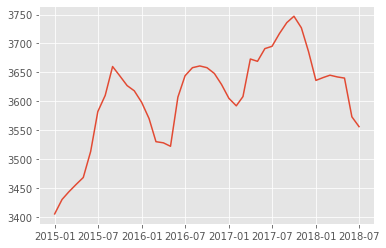

In [53]:
print(ny_train_rent.rolling(3).mean().head(10))
plt.plot(ny_train_rent)

(0.0, 0.5)

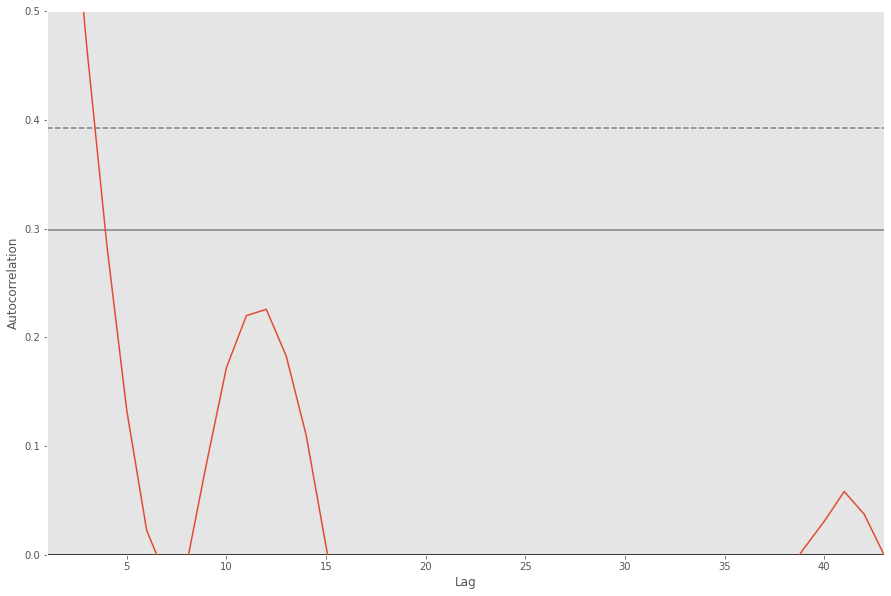

In [54]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize = (15,10))
autocorrelation_plot(ny_train_rent)
plt.ylim([0,0.5])

In [55]:
from statsmodels.tsa.arima.model import ARIMA

In [56]:
training_rent = ny_train_rent.copy()
training_rent.index = training_rent.index.to_period('M')
model = ARIMA(training_rent, order = (15,1,0))

In [57]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rent   No. Observations:                   43
Model:                ARIMA(15, 1, 0)   Log Likelihood                -190.894
Date:                Tue, 30 Mar 2021   AIC                            413.788
Time:                        18:04:52   BIC                            441.590
Sample:                    01-31-2015   HQIC                           423.979
                         - 07-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3898      0.247      1.579      0.114      -0.094       0.874
ar.L2          0.4001      0.268      1.493      0.135      -0.125       0.925
ar.L3         -0.3158      0.324     -0.976      0.3

In [58]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ny_train_rent, autolag='AIC', maxlag = 15 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [59]:
print(dfoutput)
print('Dickey-Fuller results indicate time series is non-stationary.')

Test Statistic                 -2.674761
p-value                         0.078508
#Lags Used                      1.000000
Number of Observations Used    41.000000
dtype: float64
Dickey-Fuller results indicate time series is non-stationary.


In [60]:
first_diff = np.diff(ny_train_rent)
dftest = adfuller(first_diff, autolag='AIC', maxlag = 15 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 -3.815252
p-value                         0.002755
#Lags Used                      0.000000
Number of Observations Used    41.000000
dtype: float64
Taking first derivative makes it stationary


,0
count,43.000000
mean,81.273007
std,519.429800
min,-50.587052
25%,-11.161825
50%,2.268029
75%,13.921369
max,3405.000000


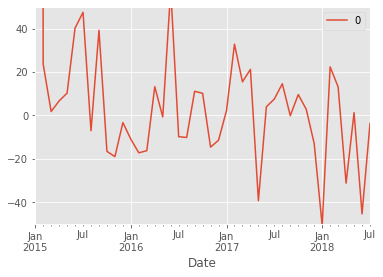

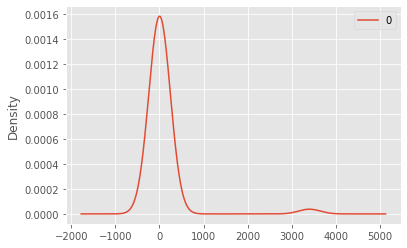

In [61]:
print(dfoutput)
print('Taking first derivative makes it stationary')

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

plt.ylim([-50,50])

residuals.plot(kind='kde')

residuals.describe()

In [62]:
# split into train and test sets
from sklearn.metrics import mean_squared_error
X = ny_train_rent.values
train, test = ny_train_rent.values, ny_test_rent.values
history = [x for x in train]
predictions = list()
# walk-forward validation
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast(typ = 'levels') # steps = len(test)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs) # issue is that we add one step after
#     print('predicted=%f, expected=%f' % (yhat, obs))
    

model = ARIMA(history, order=(15,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(typ = 'levels', steps = len(test)) # steps = len(test)
# yhat = output[0]
# predictions.append(yhat)
# obs = test[t]
# history.append(obs) # issue is that we add one step after
# print('predicted=%f, expected=%f' % (yhat, obs))

for yhat in forecast:
    predictions.append(yhat)

Test RMSE: $52.73


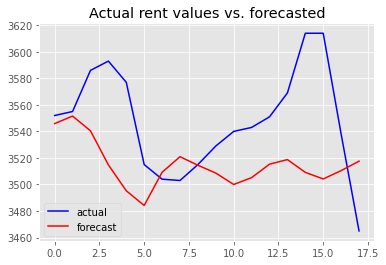

In [63]:
# evaluate forecasts
rmse = mean_squared_error(ny_test_rent, predictions,squared = False)
print('Test RMSE: $%.2f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, color = 'blue')
plt.plot(predictions, color='red')
plt.legend(['actual','forecast'])
plt.title('Actual rent values vs. forecasted')
plt.show()

# Model prediction comparisons

(3450.0, 3750.0)

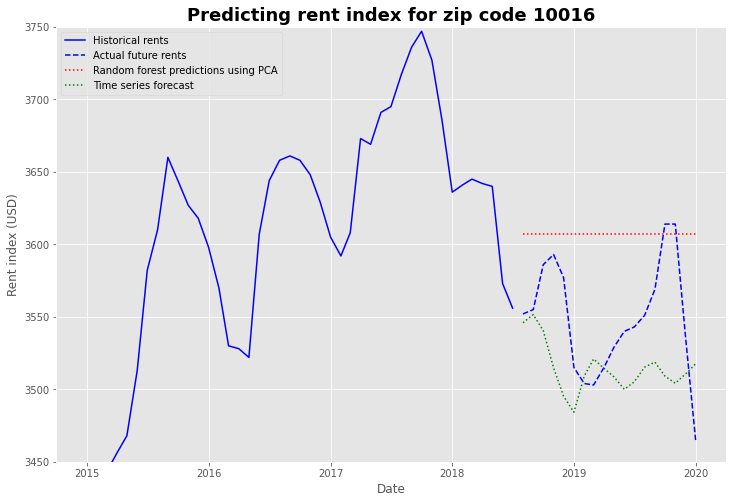

In [64]:
plt.figure(figsize = (12,8))
plt.plot(ny_train_rent,'b')
plt.plot(ny_test_rent,'b--')
plt.plot(np.exp(pca_predictors),'r:')
plt.plot(pd.Series(predictions,index = ny_test_rent.index),'g:')


plt.legend(['Historical rents','Actual future rents',
            'Random forest predictions using PCA',
            'Time series forecast'],loc = 'upper left')
plt.title('Predicting rent index for zip code 10016', fontsize = 18, fontweight = 'bold')
plt.xlabel('Date')
plt.ylabel('Rent index (USD)')
plt.ylim([3450,3750])

<p>While the random forest models are consistent, their predictions do not change over time. The ARIMA forecasts have the lowest error, but there is still a lag and it cannot match the actual peak in rents at the end of 2019.</p>